In [92]:
# Mount drive
import os
from google.colab import drive
%cd /content
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Colab Notebooks/NLP/project/code'
%ls -l
print(os.listdir())

/content
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/NLP/project/code
total 2164
-rw------- 1 root root  69858 May  9 13:09 Benchmark_embeddings.ipynb
-rw------- 1 root root   3534 Apr 22 16:32 cleaning.py
-rw------- 1 root root   4160 May  9 13:07 compute_embeddings.py
-rw------- 1 root root 363996 May  9 10:48 master.zip
-rw------- 1 root root 363996 May  9 10:49 master.zip.1
-rw------- 1 root root 363996 May  9 10:52 master.zip.2
drwx------ 2 root root   4096 May  9 10:04 __pycache__/
-rw------- 1 root root  21800 Apr 25 09:06 pytorch_tuto.ipynb
drwx------ 2 root root   4096 May  1 16:25 sent2vec-master/
-rw------- 1 root root   2689 May  9 09:38 transform_dataset.py
-rw------- 1 root root 808814 May  4 08:33 Untitled0.ipynb
-rw------- 1 root root  22808 Apr 22 16:46 Untitled.ipynb
-rw------- 1 root root   3545 Apr 22 16:32 utils_cleaning.py
-rw------- 1 root root  21429 May  7 07:34 Vincent_doc2vec.ipynb
-rw------- 1 root root  20152 Apr 25 16:47 Vincent.ipynb

In [0]:
import pandas as pd
import numpy as np
import random
import re
import time
from string import punctuation
import scipy.io
import matplotlib.pyplot as plt

import nltk
import scipy.sparse as sp
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# from nltk.stem import SnowballStemmer
# nltk.download('punkt')
# from nltk.stem import WordNetLemmatizer 
# nltk.download('wordnet')

# from gensim.test.utils import datapath, get_tmpfile
# from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec

import torch
import torch.nn as nn
from torchtext.data import Field, LabelField, TabularDataset, Iterator, BucketIterator
from torchtext import vocab
import torch.optim as optim

import transform_dataset
import compute_embeddings

In [0]:
questions1, questions2, is_duplicates = transform_dataset.clean_quora()
cleaned_questions1, cleaned_questions2, cleaned_is_duplicates = transform_dataset.clean_quora(output='tokenized_list')

In [0]:
iterator = transform_dataset.clean_quora(output = 'iterator_from_file')

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

def get_features(embs1, embs2):
  return np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)

def model_efficiency(embs, labels):
  model = Pipeline([
                ('clf', LogisticRegression()),
            ])
  X_train, X_valid, y_train, y_valid = train_test_split(embs, labels, train_size = 0.7, random_state=42, shuffle=True, stratify=labels)

  target_train = y_train
  target_valid = y_valid
  
  model.fit(X_train, target_train)
  
  predictions_train = model.predict(X_train)
  predictions_valid = model.predict(X_valid)

  proba_predictions_train = model.predict_proba(X_train)
  proba_predictions_valid = model.predict_proba(X_valid)

  loss_train = log_loss(target_train, proba_predictions_train)
  loss_valid = log_loss(target_valid, proba_predictions_valid)

  accuracy_train = accuracy_score(target_train, predictions_train)
  accuracy_valid = accuracy_score(target_valid, predictions_valid)

  f1_train = f1_score(target_train, predictions_train)
  f1_valid = f1_score(target_valid, predictions_valid)

  return {'loss':np.round(loss_valid,2), 'accuracy':np.round(accuracy_valid,2), 'f1':np.round(f1_valid,2)}

# Benchmark

In [0]:
processing_time = {}
metrics = {}

processing_time['doc2vec'] = 682.49
processing_time['sent2vec'] = 9.01
processing_time['SIF'] = 18.9
processing_time['SBERT'] = 3550.54

metrics['doc2vec'] = {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}
metrics['sent2vec'] = {'loss': 0.57, 'accuracy': 0.71, 'f1': 0.54}
metrics['SIF'] = {'loss': 0.58, 'accuracy': 0.69, 'f1': 0.49}
metrics['SBERT'] = {'loss': 0.42, 'accuracy': 0.8, 'f1': 0.73}

## Doc2Vec

### library reference
- https://radimrehurek.com/gensim/models/doc2vec.html

### pre-trained embeddings (would need to be changed for production)
https://wikipedia2vec.github.io/wikipedia2vec/pretrained/

In [11]:
model = compute_embeddings.Doc2Vec_model('../../../stage/embeddings/doc2vec/enwiki_dbow/doc2vec.bin')
model.load_model()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [12]:
%%time
start_time = time.time()
embs1 = model.calculate_embeddings(cleaned_questions1)
embs2 = model.calculate_embeddings(cleaned_questions2)

end_time = time.time()
processing_time['doc2vec'] = np.round(end_time-start_time,2)

CPU times: user 11min 18s, sys: 3.98 s, total: 11min 22s
Wall time: 11min 22s


In [0]:
np.save('../data/doc2vec_embeddings1.npy', embs1)
np.save('../data/doc2vec_embeddings2.npy', embs2)

In [20]:
features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
metric = model_efficiency(features, is_duplicates)
metrics['doc2vec'] = metric
print(metrics)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'doc2vec': {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}}


{'doc2vec': 682.49}


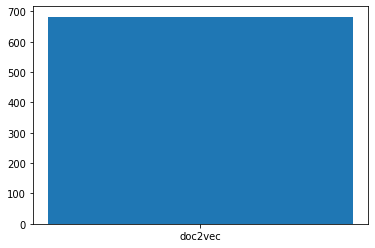

In [21]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

## Sent2Vec

### code
- https://github.com/epfml/sent2vec
- https://github.com/facebookresearch/fastText#models

### pretrained embeddings
- https://github.com/epfml/sent2vec
- https://fasttext.cc/docs/en/english-vectors.html

In [0]:
# compute_embeddings.download_and_install_git('https://github.com/epfml/sent2vec/archive/master.zip')

In [0]:
model = compute_embeddings.Sent2Vec('../../../stage/embeddings/sent2vec/sent2vec_toronto_books_unigrams')
model.load_model()

In [31]:
%%time
start_time = time.time()
embs1 = model.calculate_embeddings(questions1)
embs2 = model.calculate_embeddings(questions2)

end_time = time.time()
processing_time['sent2vec'] = np.round(end_time-start_time,2)

CPU times: user 7.67 s, sys: 1.37 s, total: 9.04 s
Wall time: 9.01 s


In [0]:
np.save('../data/sent2vec_embeddings1.npy', embs1)
np.save('../data/sent2vec_embeddings2.npy', embs2)

In [33]:
features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
metric = model_efficiency(features, is_duplicates)
metrics['sent2vec'] = metric
print(metrics)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'sent2vec': {'loss': 0.57, 'accuracy': 0.71, 'f1': 0.54}}


{'sent2vec': 9.01}


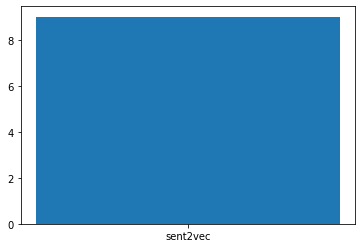

In [34]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

## SBERT (Sentence BERT)

### code and embeddings
- https://github.com/UKPLab/sentence-transformers


In [35]:
model = compute_embeddings.SBERT()
model.load_model()

100%|██████████| 405M/405M [00:07<00:00, 55.9MB/s]


In [37]:
%%time
start_time = time.time()
embs1 = np.array(model.calculate_embeddings(questions1))
embs2 = np.array(model.calculate_embeddings(questions2))

end_time = time.time()
processing_time['SBERT'] = np.round(end_time-start_time,2)

CPU times: user 46min 42s, sys: 12min 29s, total: 59min 11s
Wall time: 59min 10s


In [0]:
embs1 = np.array(embs1)
embs2 = np.array(embs2)

np.save('../data/SBERT_embeddings1.npy', embs1)
np.save('../data/SBERT_embeddings2.npy', embs2)

In [45]:
features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
metric = model_efficiency(features, is_duplicates)
metrics['SBERT'] = metric
print(metrics)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'sent2vec': {'loss': 0.57, 'accuracy': 0.71, 'f1': 0.54}, 'SBERT': {'loss': 0.42, 'accuracy': 0.8, 'f1': 0.73}}


{'sent2vec': 9.01, 'SBERT': 3550.54}


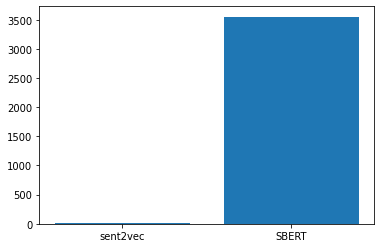

In [46]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

## SIF embedding / sentence2vec

### code
- https://github.com/oborchers/Fast_Sentence_Embeddings
- https://github.com/peter3125/sentence2vec/blob/master/sentence2vec.py
- https://gist.github.com/bluemonk482/a4b2de9b5037d9ad69fa82da6ae67641
- https://github.com/PrincetonML/SIF/blob/master/src/SIF_embedding.py

### embedding



In [0]:
model = compute_embeddings.SIF()
model.load_model()

In [0]:
model.fit(cleaned_questions1+cleaned_questions2)

In [64]:
%%time
start_time = time.time()
embs1 = model.calculate_embeddings(cleaned_questions1)
embs2 = model.calculate_embeddings(cleaned_questions2)

end_time = time.time()
processing_time['SIF'] = np.round(end_time-start_time,2)

CPU times: user 25.9 s, sys: 5.66 s, total: 31.6 s
Wall time: 18.9 s


In [0]:
# np.save('../data/SIF_embeddings1.npy', embs1)
# np.save('../data/SIF_embeddings2.npy', embs2)

In [67]:
features = np.concatenate((embs1, embs2, np.abs(embs2-embs1)), axis=1)
metric = model_efficiency(features, is_duplicates)
metrics['SIF'] = metric
print(metrics)

{'sent2vec': {'loss': 0.57, 'accuracy': 0.71, 'f1': 0.54}, 'SBERT': {'loss': 0.42, 'accuracy': 0.8, 'f1': 0.73}, 'SIF': {'loss': 0.58, 'accuracy': 0.69, 'f1': 0.49}}


{'doc2vec': 682.49, 'sent2vec': 9.01, 'SIF': 18.9, 'SBERT': 3550.54}


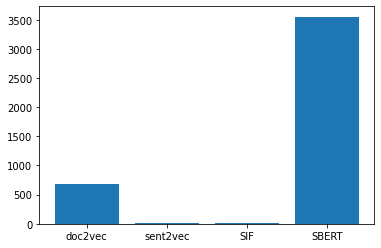

In [70]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

# Word Count

In [0]:
model = compute_embeddings.Count()
# model = Count()
model.load_model()

In [141]:
model.fit(questions1 + questions2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [142]:
%%time
start_time = time.time()
count_embs1 = model.calculate_embeddings(questions1)
count_embs2 = model.calculate_embeddings(questions2)

end_time = time.time()
processing_time['Count'] = np.round(end_time-start_time,2)

CPU times: user 6.71 s, sys: 12.3 ms, total: 6.72 s
Wall time: 6.72 s


In [0]:
# np.save('../data/Count_embeddings1.npy', count_embs1)
# np.save('../data/Count_embeddings2.npy', count_embs2)

In [0]:
import scipy.sparse.linalg
count_features, _, _ = scipy.sparse.linalg.svds(sp.vstack((count_embs1, count_embs2)).astype('float64'),
                                          k=100)
count_features1 = count_features[:len(questions1)]
count_features2 = count_features[-len(questions2):]

In [129]:
features = np.concatenate((count_features1, count_features2, np.abs(count_features2-count_features1)), axis=1)
metric = model_efficiency(features, is_duplicates)
metrics['Count'] = metrn mon notebook et je push caic
print(metrics)

{'doc2vec': {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}, 'sent2vec': {'loss': 0.57, 'accuracy': 0.71, 'f1': 0.54}, 'SIF': {'loss': 0.58, 'accuracy': 0.69, 'f1': 0.49}, 'SBERT': {'loss': 0.42, 'accuracy': 0.8, 'f1': 0.73}, 'Count': {'loss': 0.65, 'accuracy': 0.63, 'f1': 0.0}}


# TFIDF

In [0]:
model = compute_embeddings.Count()
# model = TFIDF()
model.load_model()

In [144]:
model.fit(questions1 + questions2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [145]:
%%time
start_time = time.time()
tfidf_embs1 = model.calculate_embeddings(questions1)
tfidf_embs2 = model.calculate_embeddings(questions2)

end_time = time.time()
processing_time['TFIDF'] = np.round(end_time-start_time,2)

CPU times: user 6.83 s, sys: 11.9 ms, total: 6.84 s
Wall time: 6.84 s


In [0]:
# np.save('../data/TFIDF_embeddings1.npy', tfidf_embs1)
# np.save('../data/TFIDF_embeddings2.npy', tfidf_embs2)

In [0]:
import scipy.sparse.linalg
tfidf_features, _, _ = scipy.sparse.linalg.svds(sp.vstack((tfidf_embs1, tfidf_embs2)).astype('float64'),
                                          k=100)
tfidf_features1 = tfidf_features[:len(questions1)]
tfidf_features2 = tfidf_features[-len(questions2):]

In [135]:
features = np.concatenate((tfidf_features1, tfidf_features2, np.abs(tfidf_features2-tfidf_features1)), axis=1)
metric = model_efficiency(features, is_duplicates)
metrics['TFIDF'] = metric
print(metrics)

{'doc2vec': {'loss': 0.54, 'accuracy': 0.71, 'f1': 0.57}, 'sent2vec': {'loss': 0.57, 'accuracy': 0.71, 'f1': 0.54}, 'SIF': {'loss': 0.58, 'accuracy': 0.69, 'f1': 0.49}, 'SBERT': {'loss': 0.42, 'accuracy': 0.8, 'f1': 0.73}, 'Count': {'loss': 0.65, 'accuracy': 0.63, 'f1': 0.0}, 'TFIDF': {'loss': 0.64, 'accuracy': 0.63, 'f1': 0.0}}


## Feature engineering

In [0]:
def jaccard_type_feature(count1, count2, eps=1e-12):
  features = (count1.multiply(count2 != 0) + count2.multiply(count1 != 0)).sum(axis=1)
  features = features / (count1.sum(axis=1) + count2.sum(axis=1) + eps)
  return features

In [152]:
count_features = jaccard_type_feature(count_embs1, count_embs2)
tfidf_features = jaccard_type_feature(tfidf_embs1, tfidf_embs2)

features = np.concatenate((count_features, tfidf_features), axis=1)
features.shape

(404290, 2)

In [154]:
metric = model_efficiency(features, is_duplicates)
metrics['Count+TFIDF'] = metric
print(metric)

{'loss': 0.55, 'accuracy': 0.67, 'f1': 0.49}


# Summary

{'doc2vec': 682.49, 'sent2vec': 9.01, 'SIF': 18.9, 'SBERT': 3550.54, 'Count': 6.78, 'TFIDF': 6.84}


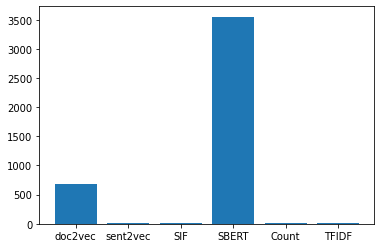

In [136]:
plt.bar(*zip(*processing_time.items()))
print(processing_time)

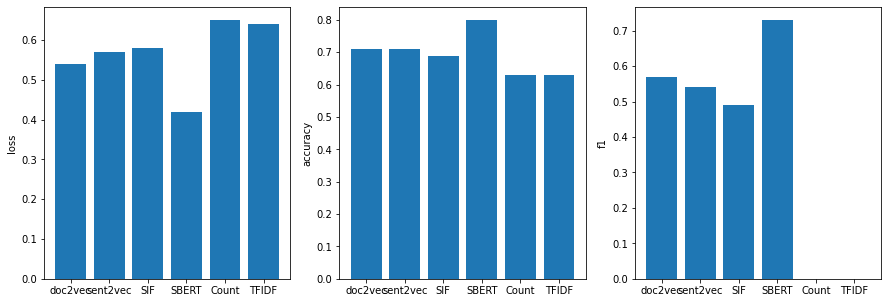

In [137]:
methods = list(metrics.keys())
measures = list(metrics[methods[0]].keys())
fig, ax = plt.subplots(ncols = len(measures), figsize = (15, 5))
for i, measure in enumerate(measures):
  ax[i].bar(methods, [metrics[method][measure] for method in methods])
  ax[i].set_ylabel(measure)